##Import and install required libraries

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Conv2D,Dense,MaxPooling2D,Dropout,BatchNormalization,Activation 
from PIL import Image
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
!pip install wandb
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 3.7 MB/s 
     |████████████████████████████████| 181 kB 35.9 MB/s 
     |████████████████████████████████| 144 kB 39.0 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=5d6f73d59c6a33500528fc24f01b25c68b5b0bded0fa8a0e43da296a1cacb222
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


##Unzip and load file data file onto server, then delete zip file for optimizing performance

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')
zip_path = "drive/MyDrive/nature_12K.zip"
!cp "{zip_path}" .
!unzip -q nature_12K.zip
!rm nature_12K.zip

Mounted at /content/drive


##Question 1

Build a small CNN model consisting of 5 convolution layers. Each convolution layer would be followed by a ReLU activation and a max pooling layer. Here is sample code for building one such conv-relu-maxpool block in keras.

In [ ]:
def convolutional_neural_network_CNN(filter_multiplier=1,num_filters=32,dropout=0.2,dense_size=64,batch_norm=False,image_size=200,num_classes=10):
    model = Sequential()
    #filter_size = [(11,11),(9,9),(7,7),(5,5),(3,3)]
    filter_size = [(3,3),(3,3),(3,3),(3,3),(3,3)]

#*************************************************************LAYER 1**********************************************************************************
    model.add(Conv2D(num_filters, filter_size[0], input_shape=(image_size, image_size, 3), data_format="channels_last"))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    num_filters = int(num_filters * filter_multiplier)
        
 
#*************************************************************LAYER 2**********************************************************************************       
        
    model.add(Conv2D(num_filters, filter_size[1]))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    num_filters = int(num_filters * filter_multiplier)


#*************************************************************LAYER 3**********************************************************************************
    model.add(Conv2D(num_filters, filter_size[2]))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    num_filters = int(num_filters * filter_multiplier)

#*************************************************************LAYER 4**********************************************************************************
    model.add(Conv2D(num_filters, filter_size[3]))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    num_filters = int(num_filters * filter_multiplier)
    

#*************************************************************LAYER 5**********************************************************************************
    model.add(Conv2D(num_filters, filter_size[4]))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Flatten())
    model.add(Dense(dense_size))
    model.add(Dropout(dropout))
    model.add(Activation("relu"))
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))

    return model

## Prepare the dataset for training

In [ ]:
def dataset_Training(Dataset_loc="inaturalist_12K", augment_data=False):
    Directory_train= os.path.join(Dataset_loc, "train")
    Directory_test= os.path.join(Dataset_loc, "val")

    if augment_data:
        generator_train=ImageDataGenerator(rescale=1./255,rotation_range=90,zoom_range=0.2,shear_range=0.2,validation_split=0.1,horizontal_flip=True)
    else:
        generator_train=ImageDataGenerator(rescale=1./255, validation_split=0.1)
       
    generator_test = ImageDataGenerator(rescale=1./255)
    train_generate = generator_train.flow_from_directory(Directory_train, target_size=(200, 200), batch_size=32, subset="training",shuffle=True,seed=8700)
    val_generate = generator_train.flow_from_directory(Directory_train, target_size=(200, 200), batch_size=32, subset="validation",shuffle=True,seed=8700)
    test_generate = generator_test.flow_from_directory(Directory_test, target_size=(200, 200), batch_size=32)
    
    return train_generate, val_generate, test_generate;

##Run names for WandB to enhance readability

In [ ]:
def wandb_run_name(filter_multiplier=2,num_filters=32,dropout=0.2,augment_data=False,batch_norm=False):
    
    augment_data_options = {True: "Y", False: "N"}
    batch_norm_options = {True: "Y", False: "N"}

    run_name = "_".join(["num", str(num_filters), "org", str(filter_multiplier), "aug", augment_data_options[augment_data],
                      "drop", str(dropout), "norm", batch_norm_options[batch_norm]])
    
    return run_name;

##Training and validation process

In [ ]:
def train():
    wandb_defaults = {
        "num_filter": 16,
        "filter_multiple": 2,
        "augment_data": False,
        "dropout": 0.27,
        "batch_normalisation": False,
        "epochs": 10,
        "dense_size": 32,
        "lr": 0.0001
    }

    wandb.init(config=wandb_defaults, magic=True)
    config = wandb.config
    wandb.run.name = wandb_run_name(config.filter_multiple,config.num_filter,config.dropout,config.batch_normalisation,config.augment_data)
    train_generator, val_generator, test_generator = dataset_Training(augment_data=config.augment_data)
    model = convolutional_neural_network_CNN(filter_multiplier=config.filter_multiple,num_filters=config.num_filter,dropout=config.dropout,dense_size=config.dense_size, batch_norm=config.batch_normalisation)
    model.compile(optimizer=keras.optimizers.Adamax(config.lr), loss="categorical_crossentropy", metrics="categorical_accuracy")
    model.fit(train_generator, epochs=config.epochs, validation_data=val_generator, callbacks=[WandbCallback()])

    print("Evaluating Our Model:")
    y=model.evaluate(test_generator, batch_size=32)
    #print(y)
    predictions = model(test_generator[0][0])
    test_results_plot(test_generator, predictions, test_generator[0][1])
    sample_num =16
    filters_plot(model, test_generator, sample_num)
    wandb.log({"Test_accuracy":y[1]})
    model.save("Best_model.h5")

##Visualise feature maps from the first Conv layer for a test image and Display sample test images with their predictions and labels

In [ ]:
def filters_plot(model, test_data, sample_num):
    sub_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
    plt.imshow(test_data[0][0][sample_num])
    plt.axis('off')
    feature_maps = sub_model(test_data[0][0])
    fig, ax = plt.subplots(4, 8, figsize=(12,6))
    for i in range(feature_maps.shape[-1]):
        ax[int(i/8), i%8].imshow(feature_maps[sample_num, :, :, i], cmap='green')
        ax[int(i/8), i%8].axis('off')
def test_results_plot(test_data, predictions, labels):
    fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(15,15))
    output_map = {0: 'Amphibia', 1: 'Animalia', 2: 'Arachnida', 3: 'Aves', 4: 'Fungi', 
                  5: 'Insecta', 6: 'Mammalia', 7: 'Mollusca', 8: 'Plantae', 9: 'Reptilia'}
    for i in range(30):
        img = test_data[0][0][i]
        ax[int(i/6), i%6].imshow(img)
        ax[int(i/6), i%6].axis('off')
        ax[int(i/6), i%6].set_aspect('equal')
        ax[int(i/6), i%6].set_title("Predicted: " + output_map[np.argmax(predictions, axis=1)[i]] + "\nLabel: " + output_map[np.argmax(labels, axis=1)[i]])

##Question 2 and 4
sweep config

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. 'Val Accuracy' is not of type 'object'


Create sweep with ID: 352xt5ox
Sweep URL: https://wandb.ai/manishiitm/CS6910_Assignment12n/sweeps/352xt5ox


wandb: Agent Starting Run: j9mhc0he with config:
wandb: 	augment_data: True
wandb: 	batch_normalisation: True
wandb: 	dense_size: 1331
wandb: 	dropout: 0.37
wandb: 	epochs: 20
wandb: 	filter_multiple: 2
wandb: 	lr: 7e-05
wandb: 	num_filter: 32
wandb: Currently logged in as: manishiitm (use `wandb login --relogin` to force relogin)


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/20
282/282 [==============================] - 265s 903ms/step - loss: 2.3230 - accuracy: 0.2217 - val_loss: 2.4185 - val_accuracy: 0.1121 - _timestamp: 1649450982.0000 - _runtime: 276.0000
Epoch 2/20
282/282 [==============================] - 215s 761ms/step - loss: 2.0418 - accuracy: 0.2774 - val_loss: 2.0446 - val_accuracy: 0.2713 - _timestamp: 1649451254.0000 - _runtime: 548.0000
Epoch 3/20
282/282 [==============================] - 212s 750ms/step - loss: 1.9814 - accuracy: 0.2959 - val_loss: 1.9475 - val_accuracy: 0.3243 - _timestamp: 1649451466.0000 - _runtime: 760.0000
Epoch 4/20
282/282 [==============================] - 215s 763ms/step - loss: 1.9317 - accuracy: 0.3192 - val_loss: 1.9345 - val_accuracy: 0.3213 - _timestamp: 1649451681.0000 - _runtime: 975.0000
Epoch 5/20
282/282 [==============================] - 213s 755ms/step - loss: 1.9125

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


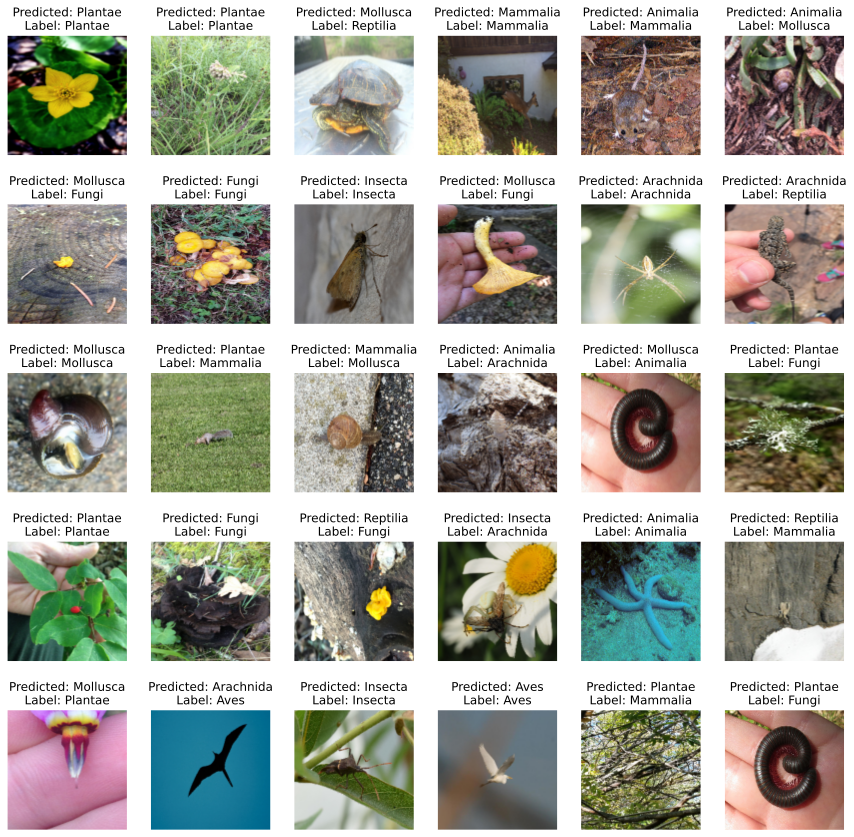

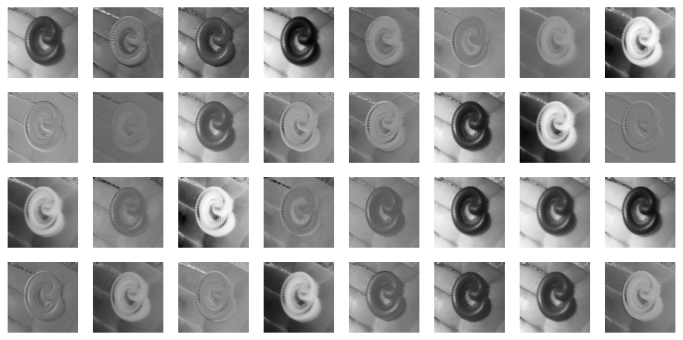

In [ ]:

sweep_config = {
    "metric": "Val Accuracy",
    "method": "random",
    "project": "CS6910_Assignment2",
    "parameters": {
        "num_filter": {
            "values": [16,32,64]
        },
        "filter_multiple": {
            "values": [1,0.5,1.5,2]
        },
        "augment_data": {
            "values": [True,False]
        },
        "dropout": {
            "values": [0.2,0.27,0.37,0.5]
        },
        "batch_normalisation": {
            "values": [True,False]
        },
        "dense_size": {
            "values": [32,64,128,256,512,1024,1331]
        },
        "lr": {
            "values": [0.00007,0.00008]
        },
        "epochs": {
            "values": [5,12]
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="CS6910_Assignment12n")
wandb.agent(sweep_id, function=train)

##Question 5
###guided back propagation

In [ ]:
def Guided_Back_Propagation(model_dir, n_images,image_size=200,augment_data=False):
    Dataset_loc="inaturalist_12K"
    #loading the data and the model
    Directory_train = os.path.join(Dataset_loc, "train")
    Directory_test = os.path.join(Dataset_loc, "val")
    if augment_data:
        train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=90,zoom_range=0.2,shear_range=0.2,horizontal_flip=True)
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(Directory_train, target_size=(image_size, image_size), batch_size=256)
    test_generator = test_datagen.flow_from_directory(Directory_test, target_size=(image_size, image_size), batch_size=256)

    model = tf.keras.models.load_model(model_dir)#load Model
    # take upto 5th conv_layer
    model_upto_5 = tf.keras.models.Model([model.inputs],[model.get_layer("conv2d_4").output])

    # creating a custom gradient 
    @tf.custom_gradient
    def guidedRelU(x):
        def grad(dy):
            return tf.cast(dy>0, tf.float32) * tf.cast(x>0, tf.float32) * dy
        return tf.nn.relu(x), grad

    for layer in model.layers[1:]:
        if hasattr(layer, 'activation') and layer.activation==tf.keras.activations.relu:
            layer.activation = guidedRelU
    fig, axs = plt.subplots(n_images, 2, figsize=(2*4, n_images*4))# plot the images
    inputs = tf.convert_to_tensor(test_generator[0][0][:n_images], dtype=tf.float32)

    for i in range(n_images):
        with tf.GradientTape() as tape:
            input = tf.expand_dims(inputs[i], 0)
            tape.watch(input)
            output =model_upto_5 (input)[0]
        gradients = tape.gradient(output,input)[0]

        axs[i][0].set_title("Before BackProp")
        axs[i][0].imshow(inputs[i])
        axs[i][1].set_title("After Guided backpropagation")
        axs[i][1].imshow(gradients)
    plt.savefig('backprop.png')
    plt.show()

In [ ]:
Guided_Back_Propagation("Best_model.h5", 11,image_size=200,augment_data=True)

Found 9999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i